## imports

In [43]:
import collections
import glob
import json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage
import uuid

## utilities

### I/O

In [240]:
def read_events(fname):
    events = []
    state = {}

    with open(fname, 'r') as f:
        begin_time = np.nan
        solve_time = np.nan
        for line in f:
            entries = line.split("|")
            # Python version uses '|', too
            entries = entries[:4] + ["|".join(entries[4:])]

            (time_stamp,
             level,
             logger,
             function,
             msg) = [s.strip() for s in entries]

            if (logger, function) == ("fipy.solvers", "<module>"):
                pass
            elif (level, logger, function) == ("DEBUG", "fipy", "<module>"):
                versions = json.loads(msg)
                # # fix name collision
                # versions["package"]["solver_suite"] = versions["package"]["solver"]
                # del versions["package"]["solver"]
            elif (level, function) == ("DEBUG", "<module>"):
                if msg.startswith("result stored in"):
                    continue
                if "uuid" in state:
                    cached_uuid = state["uuid"]
                else:
                    cached_uuid = np.nan
                state = json.loads(msg)
                state["time_stamp"] = time_stamp
                state["solver_class"] = logger.split('.')[-1]
                state["solve_time"] = str(solve_time)
                if state["state"] == "START":
                    state["uuid"] = uuid.uuid4()
                    converged = False
                elif state["state"] == "END":
                    state["uuid"] = cached_uuid
                    state["converged"] = converged
                state.update(versions)
                events.append(state.copy())
            elif (level, function) == ("DEBUG", "_setConvergence"):
                state["state"] = "SWEEP"
                event = json.loads(msg)
                event.update(state.copy())
                event["time_stamp"] = time_stamp
                event["solver_class"] = logger.split('.')[-1]
                event["solve_time"] = str(solve_time)
                converged = event["status_name"] in ['KSP_CONVERGED_RTOL', 'SCIPY_SUCCESS', 'AZ_normal', 'KSP_CONVERGED_ITS', 'KSP_CONVERGED_RTOL', 'Pysparse_CONVERGED_RTOL', 'AMGX_SOLVE_SUCCESS']
                events.append(event)
            elif (level, function) == ("DEBUG", "_solve_"):
                if msg == "BEGIN solve":
                    begin_time = pd.to_datetime(time_stamp)
                    solve_time = np.nan
                elif msg == "END solve":
                    solve_time = pd.to_datetime(time_stamp) - begin_time
                    begin_time = np.nan

    return events

def events2df(events):
    df = pd.json_normalize(events)
    df["time_stamp"] = pd.to_datetime(df["time_stamp"])
    df["solve_time"] = pd.to_timedelta(df["solve_time"])    
    df.loc[df["preconditioner"].isna()
           | (df["preconditioner"] == "NoneType"), "preconditioner"] = "unpreconditioned"

    return df

def extract_total_times(df):
    df2 = df[df["state"].isin(["START", "END"])].copy()
    df2["time_delta"] = df2["time_stamp"].diff()
    df2["elapsed_seconds"] = df2["time_delta"] / pd.Timedelta("00:00:01")

    return df2[df2["state"] == "END"].sort_values("numberOfElements")

def extract_sweep_times(df):
    df2 = df.copy()
    df2["time_delta"] = df["time_stamp"].diff()
    df2["elapsed_seconds"] = df2["time_delta"] / pd.Timedelta("00:00:01")

    return df2[~df2["state"].isin(["START", "END"])]

### miscellaneous

In [39]:
def is_converged(paths, df):
    converged = {}
    for path in paths:
        suite, solver, preconditioner, numberOfElements = path.split('/')[-5:-1]
        if preconditioner == "NoneType":
            preconditioner = "unpreconditioned"
        status = df[(df['package.solver'] == suite)
                    & (df['solver_class'] == solver)
                    & (df['preconditioner'] == preconditioner)
                    & (df['numberOfElements'] == int(numberOfElements))
                    & (df['state'] == "SWEEP")].iloc[-1]['status_name']

        converged[path] = status in ["KSP_CONVERGED_RTOL", "SCIPY_SUCCESS"]

    return converged

### plot scaling

In [310]:
def plot_all(df, color_by_suite=True,
             group_by=["package.solver", "solver_class", "preconditioner"]):
    color_map = {
        'no-pysparse': 'red',
        'petsc': 'blue',
        'scipy': 'green',
        'pysparse': 'orange',
        'pyamgx': 'cyan'
    }
    
    fig, ax = plt.subplots(figsize=(8,6))
    groups = df.groupby(group_by + ["numberOfElements"])
    groups = groups.agg(converged=("converged", "mean"),
                        count=("elapsed_seconds", "count"),
                        mean=("elapsed_seconds", "mean"),
                        std=("elapsed_seconds", "std")).reset_index()
    groups = groups.groupby(group_by)
    for key, group in groups:
        if color_by_suite:
            color = color_map[key[0]]
            group.mask(~group["converged"].astype(bool)).plot("numberOfElements", "mean", loglog=True,
                       ax=ax, label=key, color=color, marker=".", markersize=1)
            group.mask(group["converged"].astype(bool)).plot("numberOfElements", "mean", loglog=True,
                       ax=ax, label=None, color=color, marker="x", linestyle="")
        else:
            group.mask(~group["converged"].astype(bool)).plot("numberOfElements", "mean", loglog=True,
                       ax=ax, label=key, marker=".", markersize=1)
            color = ax.lines[-1].get_color()
            group.mask(group["converged"].astype(bool)).plot("numberOfElements", "mean", loglog=True,
                       ax=ax, label=None, color=color, marker="x", linestyle="")
            
        # plot uncertainty
        err = group["std"] / np.sqrt(group["count"])
        ax.fill_between(group["numberOfElements"],
                        group["mean"] - err,
                        group["mean"] + err,
                        color=color,
                        alpha=0.1)

    # only label converged lines
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::2], labels[::2], bbox_to_anchor=(1., 1.))

    ax.set_ylabel("elapsed time / s")
    ax.set_xlabel("number of elements")

def plot_by_solver(df):
    for solver_class, group1 in df.groupby(["solver_class"]):
        plot_all(group1, group_by=["package.solver", "preconditioner"])
        plt.title(solver_class)
        
def plot_sweep_times(df):
    for numberOfElements, group1 in df.groupby("numberOfElements"):
        fig, ax = plt.subplots(figsize=(8,6))
        for label, group2 in group1.groupby(["package.solver", "solver_class", "preconditioner"]):
            group2 = group2.reset_index()
            group2.plot(y="elapsed_seconds", ax=ax, label=label, logy=True)
        _ = plt.xlim(xmax=9)
        plt.legend(loc="upper right", bbox_to_anchor=(1.7, 1.0))
        plt.title("size = {0}x{0}".format(int(np.sqrt(numberOfElements))))
        plt.ylabel("sweep time / s")
        plt.xlabel("sweep")        

### plot solutions

In [41]:
def sort_directories_numerically(paths):
    splitted = [s.split('/') for s in paths]
    splitted = [s[:-2] + [int(s[-2]), s[-1]] for s in splitted]
    splitted.sort()
    splitted = [s[:-2] + [str(s[-2]), s[-1]] for s in splitted]
    return ['/'.join(s) for s in splitted]

def read_tsv(tsv):
    x, y, v = np.loadtxt(tsv, skiprows=1, unpack=True)
    N = int(np.sqrt(len(x)))
    return [field.reshape((N,N)) for field in (x, y, v)] + [N]

def read_npz(npz):
    data = np.load(npz)
    return data["x"], data["y"], data["value"], data["value"].shape[0]

def tsv2npz(tsv):
    x, y, v, N = read_tsv(tsv)
    np.savez(os.path.splitext(tsv)[0], x=x, y=y, value=v)

def compare(coarse, fine):
    # "gpu/pyamgx/LinearGMRESSolver/10000/solution.tsv"
    x_coarse, y_coarse, v_coarse, N_coarse = read_tsv(coarse)
    x_fine, y_fine, v_fine, N_fine = read_tsv(fine)

    fig = plt.figure(figsize=(16,12))
    ax1 = fig.add_subplot(131)  # coarse
    ax2 = fig.add_subplot(132)  # error
    ax3 = fig.add_subplot(133)  # fine
    resampled = ndimage.zoom(v_fine, N_coarse / N_fine)
    ax1.imshow(v_coarse, vmin=v_fine.min(), vmax=v_fine.max())
    ax2.imshow(resampled-v_coarse, vmin=v_fine.min(), vmax=v_fine.max())
    ax3.imshow(resampled, vmin=v_fine.min(), vmax=v_fine.max())

    ax2.set_title("{0}x{0}: L2(error) = {1}".format(N_coarse, np.sqrt(((resampled - v_coarse)**2)).sum() / N_coarse**2))

def get_diff(path1, path2, key="value"):
    """Load and intorpolate `path2` to resolution of `path1`
    
    Parameters
    ----------
    path1, path2 : str
        Paths to `.npz` files containing x-coordinates, y-coordinates, and values
        for square arrays of values.
    key : str
        Key holding data of interest

    Returns
    -------
    diff : ndarray
        Difference between `path1` and `path2`
        (at resolution of whichever is lower).
    norm : float
        L2-norm of `diff`.
    N1, N2 : float
        Dimensions of `path1` and `path2`.
    """
    # x1, x1, v1, N1 = read_npz(path1)
    # x2, x2, v2, N2 = read_npz(path2)

    data1 = np.load(path1)
    data2 = np.load(path2)
    
    v1 = data1[key]
    v2 = data2[key]
    
    N1 = v1.shape[0]
    N2 = v2.shape[0]

    if N1 == N2:
        diff = v2 - v1
        L2norm = np.sqrt((diff**2).sum()) / N1**2
    elif N2 > N1:
        resampled = ndimage.zoom(v2, N1 / N2)
        diff = resampled-v1
        L2norm = np.sqrt((diff**2).sum()) / N1**2
    else:
        resampled = ndimage.zoom(v1, N2 / N1)
        diff = v2 - resampled
        L2norm = np.sqrt((diff**2).sum()) / N2**2
    
    return diff, L2norm, N1, N2    

In [5]:
def count_path_components(paths, skip=0):
    label_counts = []
    split_paths = [path.split('/') for path in paths]
    # walk backwards through path components and collect common entries
    for i in range(skip,len(paths[0].split('/'))):
        labels = [path[-(i+1)] for path in split_paths]
        label_counts.append(collections.Counter(labels))

    return label_counts

def squeeze_runs_of_one(label_counts):
    previous_len = -1
    squeezed_labels = []
    for level in label_counts:
        if len(level) == 1:
            # all paths have the same value at this level
            if previous_len == 1:
                # prepend the cache with the new label
                key_prev, num_prev = squeezed_labels.pop().most_common()[0]
                key_new, num_new = level.most_common()[0]
                level = [f"{key_new} - {key_prev}"] * num_prev
                level = collections.Counter(level)

        previous_len = len(level)
        squeezed_labels.append(level)

    return squeezed_labels

In [40]:
def plot_error_matrix(patternA, patternB, df, key="value"):
    pathsA = glob.glob(patternA)
    pathsB = glob.glob(patternB)

    pathsA = sort_directories_numerically(pathsA)
    pathsB = sort_directories_numerically(pathsB)

    NA = len(pathsA)
    NB = len(pathsB)

    convergedA = is_converged(pathsA, df)
    convergedB = is_converged(pathsB, df)

    fig, axs = plt.subplots(nrows=NB, ncols=NA, figsize=(10, 10 * NB / NA))
    plt.setp(axs.flat, xticks=[], yticks=[])

    converged_cmap = mpl.cm.get_cmap('viridis').copy()
    converged_cmap.set_bad(color='black')

    diverged_cmap = mpl.cm.get_cmap('inferno').copy()
    diverged_cmap.set_bad(color='black')

    for col, pathA in zip(axs.T, pathsA[:NA]):
        for ax, pathB in zip(col, pathsB[:NB]):
            diff, norm, N1, N2 = get_diff(pathA, pathB, key)
            
            if convergedA[pathA] & convergedB[pathB]:
                cmap = converged_cmap
            else:
                cmap = diverged_cmap
            ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)

    for ax, pathA in zip(axs[0], pathsA):
        segments = pathA.split('/')
        if convergedA[pathA]:
            color = "black"
        else:
            color = "red"
        ax.set_title('{0}x{0}'.format(int(np.sqrt(float(segments[-2])))), size=8,
                     rotation=90, fontdict={'color': color})
    for ax, pathB in zip(axs[:, 0], pathsB):
        segments = pathB.split('/')
        if convergedB[pathB]:
            color = "black"
        else:
            color = "red"
        ax.set_ylabel('{0}x{0}'.format(int(np.sqrt(float(segments[-2])))), size=8,
                      ha="right", va='center', rotation=0, fontdict={'color': color})

    label_counts = squeeze_runs_of_one(count_path_components(pathsA, skip=2))
    for i, level in enumerate(label_counts):
        offset = 0
        for label, count in level.items():
            idx = offset + count // 2
            if label == "NoneType":
                label = "unpreconditioned"
            axs[0, idx].annotate(label, (0.5, 1), xytext=(0, 60 + 20 * i),
                                 textcoords='offset points', xycoords='axes fraction',
                                 ha='center', va='center', size=8)
            offset += count

    label_counts = squeeze_runs_of_one(count_path_components(pathsB, skip=2))
    for i, level in enumerate(label_counts):
        offset = 0
        for label, count in level.items():
            idx = offset + count // 2
            if label == "NoneType":
                label = "unpreconditioned"
            axs[idx, 0].annotate(label, (0.5, 1), xytext=(-(70 + 20 * i), 0),
                                 textcoords='offset points', xycoords='axes fraction',
                                 ha='center', va='center', size=8, rotation=90)
            offset += count

## macOS

In [ ]:
macos = events2df(read_events("macos.log"))
macos_total = extract_total_times(macos)

In [371]:
macos.loc[0, "id"]

UUID('4e5e6149-b5e4-4f36-8d81-b7efd586d2f2')

In [382]:
asolve = macos[macos["id"] == uuid.UUID('4e5e6149-b5e4-4f36-8d81-b7efd586d2f2')]

In [383]:
asolve.keys()

Index(['state', 'numberOfElements', 'sweeps', 'preconditioner', 'time_stamp',
       'solver_class', 'id', 'python', 'fipy', 'numpy', 'pysparse', 'scipy',
       'matplotlib', 'mpi4py', 'petsc4py', 'pyamgx', 'PyTrilinos', 'mayavi',
       'gmsh', 'solver_suite', 'solver', 'iterations', 'residual', 'criterion',
       'actual_code', 'status_name', 'status_code', 'max_iterations',
       'ksp_solver', 'ksp_precon', 'ksp_norm_type', 'solve_time',
       'scaled_residual', 'convergence_residual', 'Aztec_version'],
      dtype='object')

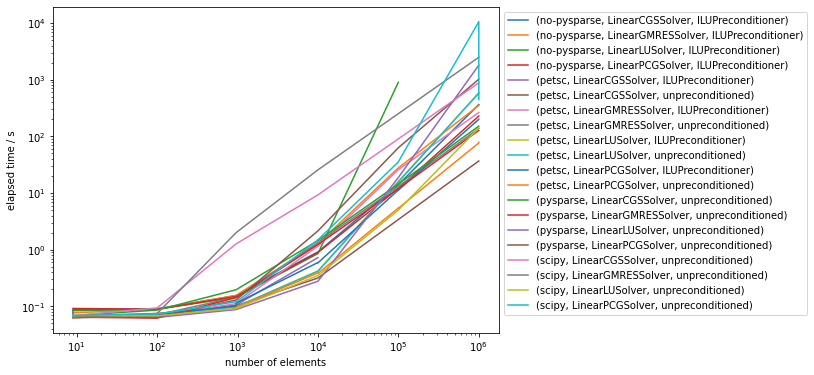

In [322]:
plot_all(macos_total)

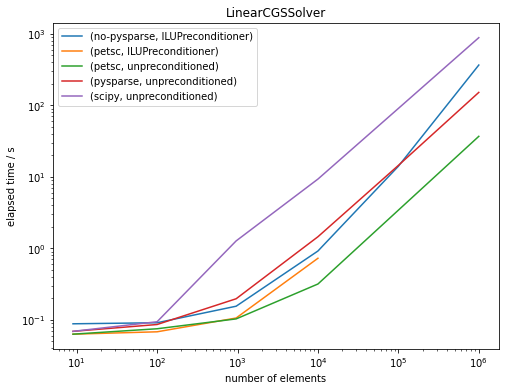

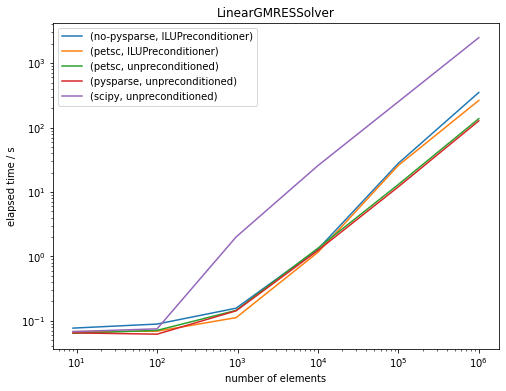

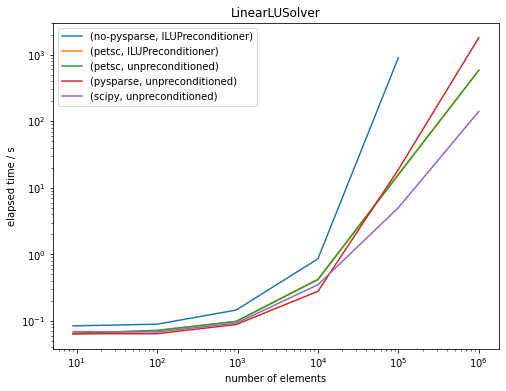

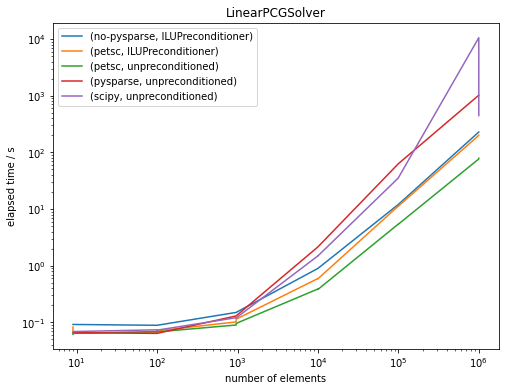

In [323]:
plot_by_solver(macos_total)

In [324]:
macos_sweep = extract_sweep_times(macos)

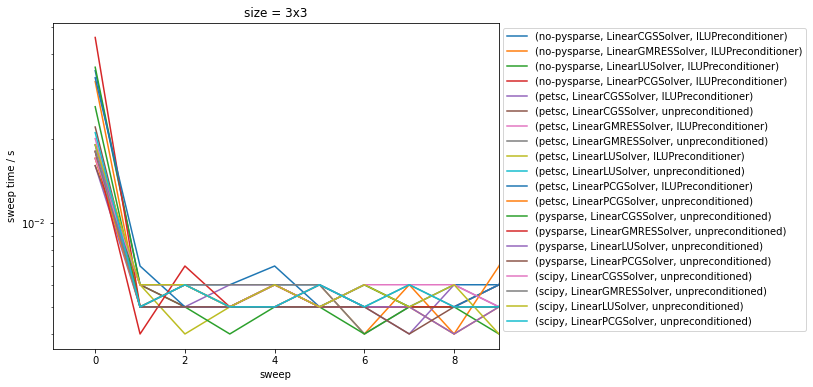

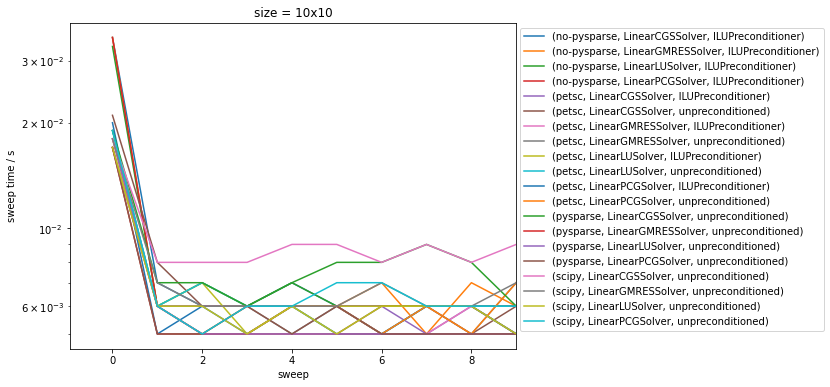

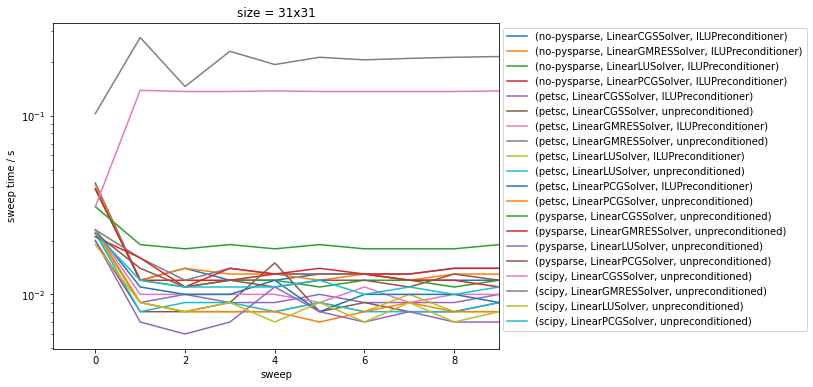

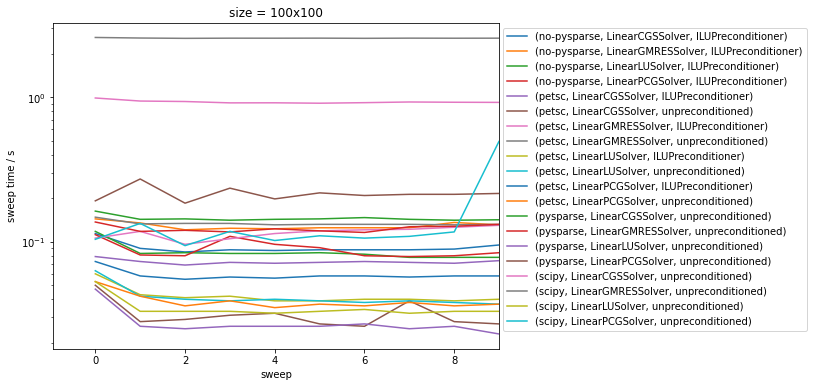

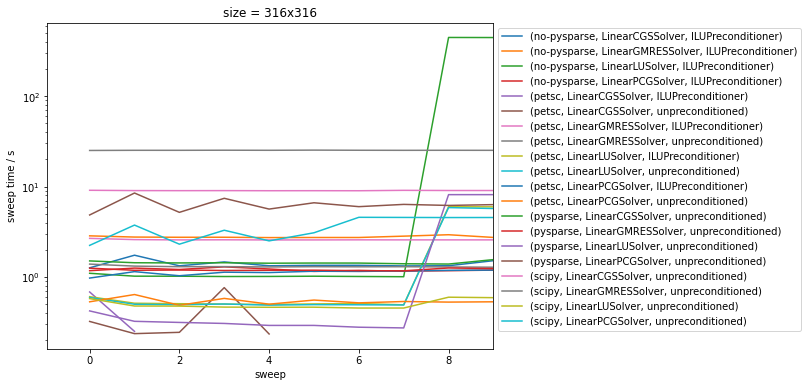

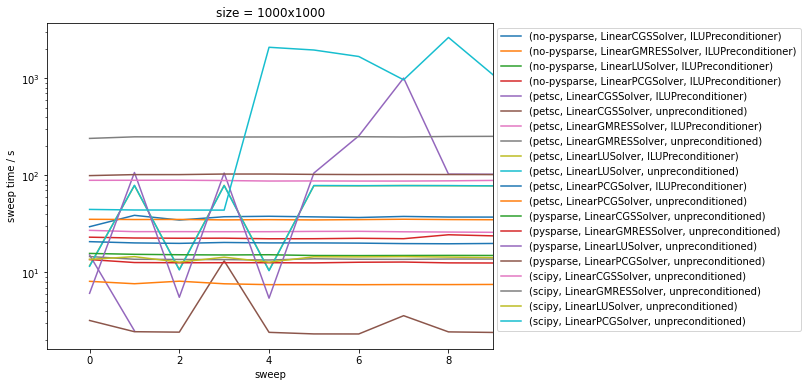

In [328]:
plot_sweep_times(macos_sweep)

## GPUs

In [329]:
gpu = events2df(read_events("gpu.log"))
gpu_total = extract_total_times(gpu)

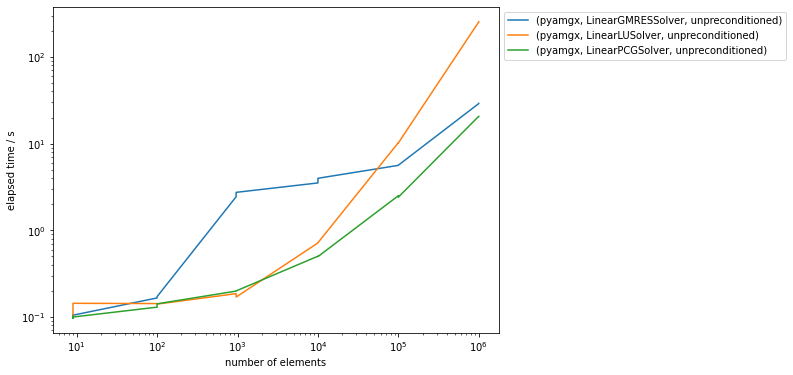

In [330]:
plot_all(gpu_total)

In [331]:
gpu_sweep = extract_sweep_times(gpu)

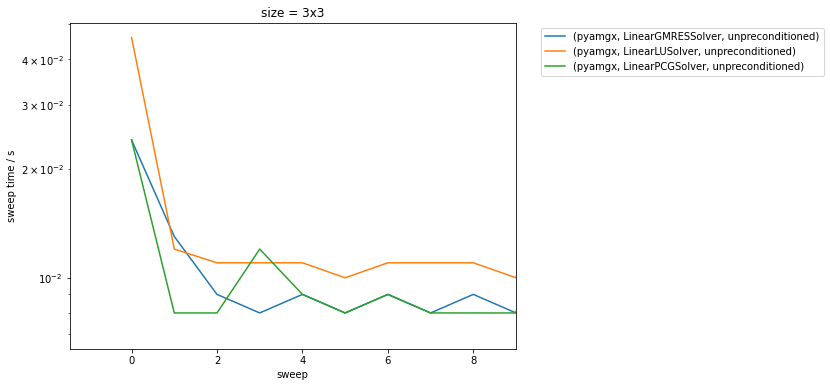

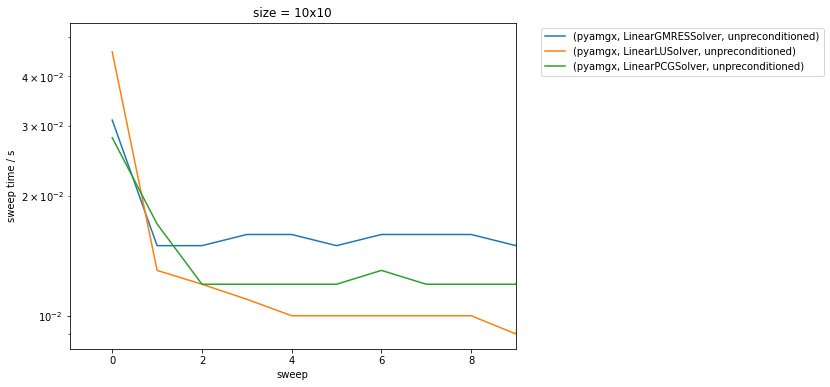

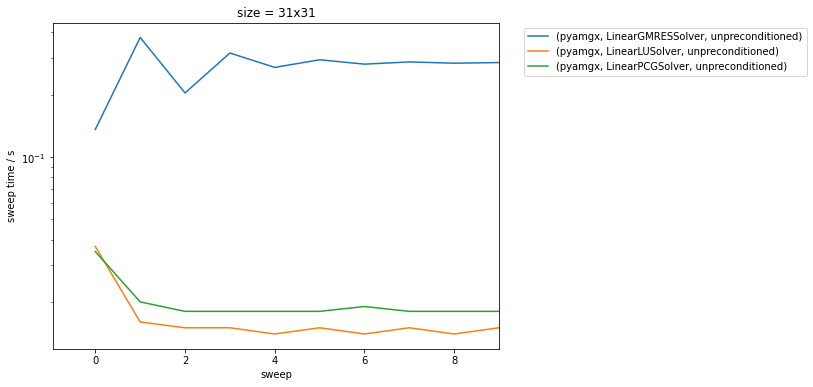

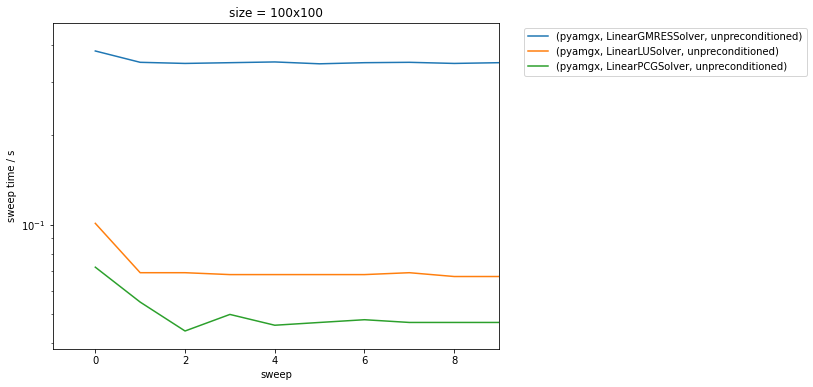

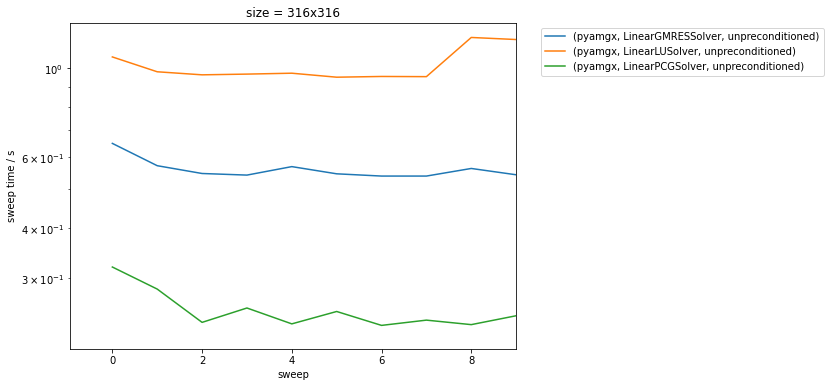

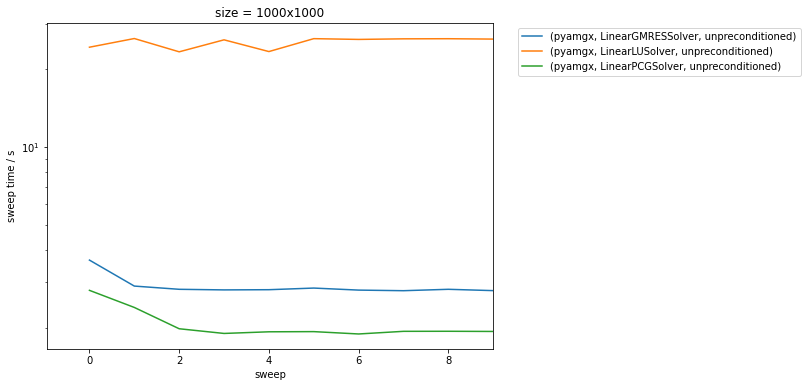

In [332]:
plot_sweep_times(gpu_sweep)

## Linux

In [131]:
events = []
for fname in glob.glob("linux/linux.*.log"):
    events.extend(read_events(fname))

linux = events2df(events)
linux_total = extract_total_times(linux)

UnboundLocalError: local variable 'versions' referenced before assignment

In [261]:
solves = linux.groupby("uuid")

In [262]:
solves["time_stamp"].diff()

0                        NaT
1     0 days 00:00:00.034000
2     0 days 00:00:00.012000
3     0 days 00:00:00.010000
4     0 days 00:00:00.011000
               ...          
272   0 days 00:00:00.010000
273   0 days 00:00:00.009000
274   0 days 00:00:00.010000
275   0 days 00:00:00.009000
276   0 days 00:00:00.010000
Name: time_stamp, Length: 256, dtype: timedelta64[ns]

In [263]:
linux["time_stamp"].diff()

0                        NaT
1     0 days 00:00:00.034000
2     0 days 00:00:00.012000
3     0 days 00:00:00.010000
4     0 days 00:00:00.011000
               ...          
273   0 days 00:00:00.009000
274   0 days 00:00:00.010000
275   0 days 00:00:00.009000
276   0 days 00:00:00.010000
277          0 days 00:00:00
Name: time_stamp, Length: 278, dtype: timedelta64[ns]

In [264]:
linux["solve_time"] = pd.to_timedelta(linux["solve_time"])
linux["elapsed_time"] = linux["time_stamp"].diff()

In [265]:
linux[["solve_time", "elapsed_time"]]

solve_time           elapsed_time
0                      NaT                    NaT
1          0 days 00:00:00 0 days 00:00:00.034000
2          0 days 00:00:00 0 days 00:00:00.012000
3          0 days 00:00:00 0 days 00:00:00.010000
4   0 days 00:00:00.001000 0 days 00:00:00.011000
..                     ...                    ...
273        0 days 00:00:00 0 days 00:00:00.009000
274        0 days 00:00:00 0 days 00:00:00.010000
275        0 days 00:00:00 0 days 00:00:00.009000
276        0 days 00:00:00 0 days 00:00:00.010000
277        0 days 00:00:00        0 days 00:00:00

[278 rows x 2 columns]

In [266]:
solves.aggregate

<bound method DataFrameGroupBy.aggregate of <pandas.core.groupby.generic.DataFrameGroupBy object at 0x17be41450>>

In [267]:
linux.groupby("uuid")[["solve_time", "elapsed_time"]].sum(numeric_only=False)

solve_time  \
uuid                                                          
011ff832-3b7e-4dfd-b535-0b835391cc92 0 days 00:00:05.589000   
05ccc533-c3db-4958-8422-fec537c06bac 0 days 00:00:00.113000   
061b6461-8f2c-4897-8a1c-e4b83c9c1f1d 0 days 00:06:30.735000   
07180d7c-80cf-4829-8bff-e5e196c5f955 0 days 00:00:00.001000   
0a7b95f2-964a-43fe-a467-cb987844f50e 0 days 00:00:00.155000   
0d861518-a3a3-4570-8c0e-ec3a8fdc6691 0 days 00:00:00.005000   
3aefdfef-6b21-41a8-b6c0-fff1538f7d27 0 days 00:00:02.124000   
3c6f9430-ae6e-4d48-a8ba-b8b17f7805f8 0 days 00:02:46.840000   
3da619b9-d387-4379-b3fb-5bba86a5858d 0 days 00:00:00.249000   
3fc2d3cf-d743-4af5-bb65-f0e47fc71241 0 days 00:00:00.002000   
41c491e8-1dc6-4ff6-9c07-3326780808a0 0 days 00:00:03.291000   
63458c23-2510-4147-a6c7-4920ad3c4973 0 days 00:00:00.273000   
65045095-44ec-429d-bf42-3af919a1ea73 0 days 00:15:43.985000   
667bc1b4-b8e5-4fe5-9a17-53ef1f743828 0 days 00:00:00.002000   
6c09f7b9-9286-4413-b7db-088e99d83792 0 days 00:00:00.003000   
753eed3b-bda5-4461-a670-b0e33abbba7a 0 days 00:00:32.023000   
89901a97-498b-4d77-98a5-d5d7e1ac9050 0 days 00:00:00.006000   
a9542608-780c-4a74-b2d2-b31f72946aa2 0 days 00:00:00.001000   
aa8815cd-809f-4539-8351-087ac5fb6e10 0 days 00:00:23.745000   
b96bf0ed-84fd-43c9-836e-f9db774b67f6 0 days 00:00:00.016000   
c86eeda9-965b-4f3a-8bad-bc3baf6e439c 0 days 00:00:00.003000   
caa5461e-b3d7-477c-9b1d-75d8f47db041 0 days 00:00:00.008000   
daad5ac4-767c-42ff-92c9-7a94e1f3ed3c 0 days 00:00:00.002000   
dbd23c54-4523-4855-bf1b-cf26cc6d576f 0 days 00:00:26.025000   

                                                 elapsed_time  
uuid                                                           
011ff832-3b7e-4dfd-b535-0b835391cc92 -1 days +23:59:33.538000  
05ccc533-c3db-4958-8422-fec537c06bac -1 days +23:52:49.667000  
061b6461-8f2c-4897-8a1c-e4b83c9c1f1d   0 days 00:07:01.217000  
07180d7c-80cf-4829-8bff-e5e196c5f955   0 days 00:00:00.130000  
0a7b95f2-964a-43fe-a467-cb987844f50e -1 days +23:59:59.810000  
0d861518-a3a3-4570-8c0e-ec3a8fdc6691   0 days 00:00:00.060000  
3aefdfef-6b21-41a8-b6c0-fff1538f7d27   0 days 00:00:02.554000  
3c6f9430-ae6e-4d48-a8ba-b8b17f7805f8   0 days 00:03:20.485000  
3da619b9-d387-4379-b3fb-5bba86a5858d -1 days +23:59:58.050000  
3fc2d3cf-d743-4af5-bb65-f0e47fc71241   0 days 00:00:00.101000  
41c491e8-1dc6-4ff6-9c07-3326780808a0 -1 days +23:43:44.129000  
63458c23-2510-4147-a6c7-4920ad3c4973   0 days 00:00:00.660000  
65045095-44ec-429d-bf42-3af919a1ea73   0 days 00:16:22.892000  
667bc1b4-b8e5-4fe5-9a17-53ef1f743828 -1 days +23:59:59.967000  
6c09f7b9-9286-4413-b7db-088e99d83792 -1 days +23:59:59.896000  
753eed3b-bda5-4461-a670-b0e33abbba7a   0 days 00:00:08.188000  
89901a97-498b-4d77-98a5-d5d7e1ac9050 -1 days +23:59:59.981000  
a9542608-780c-4a74-b2d2-b31f72946aa2   0 days 00:00:00.034000  
aa8815cd-809f-4539-8351-087ac5fb6e10   0 days 00:00:26.926000  
b96bf0ed-84fd-43c9-836e-f9db774b67f6 -1 days +23:59:59.904000  
c86eeda9-965b-4f3a-8bad-bc3baf6e439c -1 days +23:56:32.375000  
caa5461e-b3d7-477c-9b1d-75d8f47db041 -1 days +23:59:03.516000  
daad5ac4-767c-42ff-92c9-7a94e1f3ed3c -1 days +23:59:59.523000  
dbd23c54-4523-4855-bf1b-cf26cc6d576f   0 days 00:00:56.449000

In [268]:
for solve, group in solves:
    group["solve_time"] = pd.to_timedelta(group["solve_time"])
    group["elapsed_time"] = group["time_stamp"].diff()
    print(group[["solve_time", "elapsed_time"]].sum())

solve_time     0 days 00:00:05.589000
elapsed_time   0 days 00:00:09.252000
dtype: timedelta64[ns]
solve_time     0 days 00:00:00.113000
elapsed_time   0 days 00:00:00.281000
dtype: timedelta64[ns]
solve_time     0 days 00:06:30.735000
elapsed_time   0 days 00:07:09.984000
dtype: timedelta64[ns]
solve_time     0 days 00:00:00.001000
elapsed_time   0 days 00:00:00.130000
dtype: timedelta64[ns]
solve_time     0 days 00:00:00.155000
elapsed_time   0 days 00:00:00.599000
dtype: timedelta64[ns]
solve_time     0 days 00:00:00.005000
elapsed_time   0 days 00:00:00.143000
dtype: timedelta64[ns]
solve_time     0 days 00:00:02.124000
elapsed_time   0 days 00:00:02.640000
dtype: timedelta64[ns]
solve_time     0 days 00:02:46.840000
elapsed_time   0 days 00:03:27.083000
dtype: timedelta64[ns]
solve_time     0 days 00:00:00.249000
elapsed_time   0 days 00:00:00.729000
dtype: timedelta64[ns]
solve_time     0 days 00:00:00.002000
elapsed_time   0 days 00:00:00.130000
dtype: timedelta64[ns]
solve_time

In [269]:
solves.loc[asolve["solve_time"].isna(), "solve_time"] = 0

AttributeError: 'DataFrameGroupBy' object has no attribute 'loc'

In [270]:
for solve, group in solves:
    print(solve)
    

011ff832-3b7e-4dfd-b535-0b835391cc92
05ccc533-c3db-4958-8422-fec537c06bac
061b6461-8f2c-4897-8a1c-e4b83c9c1f1d
07180d7c-80cf-4829-8bff-e5e196c5f955
0a7b95f2-964a-43fe-a467-cb987844f50e
0d861518-a3a3-4570-8c0e-ec3a8fdc6691
3aefdfef-6b21-41a8-b6c0-fff1538f7d27
3c6f9430-ae6e-4d48-a8ba-b8b17f7805f8
3da619b9-d387-4379-b3fb-5bba86a5858d
3fc2d3cf-d743-4af5-bb65-f0e47fc71241
41c491e8-1dc6-4ff6-9c07-3326780808a0
63458c23-2510-4147-a6c7-4920ad3c4973
65045095-44ec-429d-bf42-3af919a1ea73
667bc1b4-b8e5-4fe5-9a17-53ef1f743828
6c09f7b9-9286-4413-b7db-088e99d83792
753eed3b-bda5-4461-a670-b0e33abbba7a
89901a97-498b-4d77-98a5-d5d7e1ac9050
a9542608-780c-4a74-b2d2-b31f72946aa2
aa8815cd-809f-4539-8351-087ac5fb6e10
b96bf0ed-84fd-43c9-836e-f9db774b67f6
c86eeda9-965b-4f3a-8bad-bc3baf6e439c
caa5461e-b3d7-477c-9b1d-75d8f47db041
daad5ac4-767c-42ff-92c9-7a94e1f3ed3c
dbd23c54-4523-4855-bf1b-cf26cc6d576f


In [433]:
asolve = linux[linux["uuid"] == uuid.UUID('0093efb7-99b5-4454-9700-fcefb02645d1')]

In [417]:
asolve.keys()

Index(['state', 'numberOfElements', 'sweeps', 'preconditioner', 'time_stamp',
       'solver_class', 'uuid', 'python', 'fipy', 'numpy', 'pysparse', 'scipy',
       'matplotlib', 'mpi4py', 'petsc4py', 'pyamgx', 'PyTrilinos', 'mayavi',
       'gmsh', 'solver_suite', 'solver', 'iterations', 'residual', 'criterion',
       'actual_code', 'status_name', 'status_code', 'max_iterations',
       'ksp_solver', 'ksp_precon', 'ksp_norm_type', 'solve_time'],
      dtype='object')

In [434]:
# asolve.loc[asolve["solve_time"].isna(), "solve_time"] = 0
asolve["solve_time"] = pd.to_timedelta(asolve["solve_time"])

In [434]:
# asolve.loc[asolve["solve_time"].isna(), "solve_time"] = 0
asolve["solve_time"] = pd.to_timedelta(asolve["solve_time"])

In [435]:
asolve["elapsed_time"] = asolve["time_stamp"].diff()

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_57027/2222063191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asolve["elapsed_time"] = asolve["time_stamp"].diff()


In [436]:
asolve[["solve_time", "elapsed_time"]].sum()

solve_time     0 days 00:00:00.016000
elapsed_time   0 days 00:00:00.187000
dtype: timedelta64[ns]

In [ ]:
df2["time_delta"] = df2["time_stamp"].diff()
df2["elapsed_seconds"] = df2["time_delta"] / pd.Timedelta("00:00:01")

In [416]:
asolve.loc[asolve["elapsed_time"].isna(), "elapsed_time"] = 0 # pd.to_timedelta(0)
asolve["elapsed_time"] = pd.to_timedelta(asolve["elapsed_time"])

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_57027/4129826495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asolve["solve_time"] = pd.to_timedelta(asolve["solve_time"])


KeyError: 'elapsed_time'

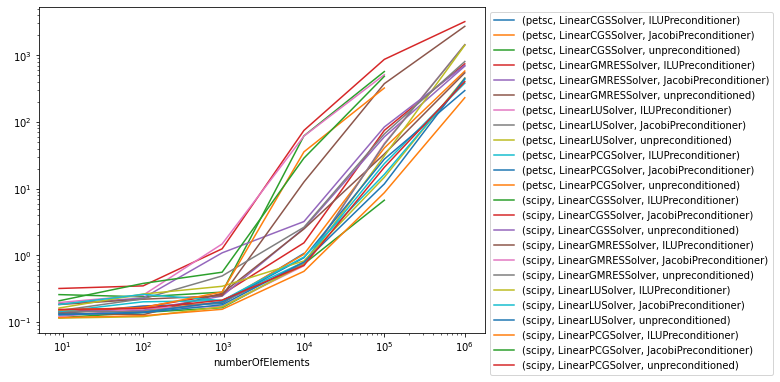

In [294]:
fig, ax = plt.subplots(figsize=(8,6))
for label, group in linuxdf.groupby(["package.solver", "solver_class", "preconditioner"]):
    group.plot("numberOfElements", "elapsed_seconds", loglog=True, ax=ax, label=label)
plt.legend(bbox_to_anchor=(1., 1.))

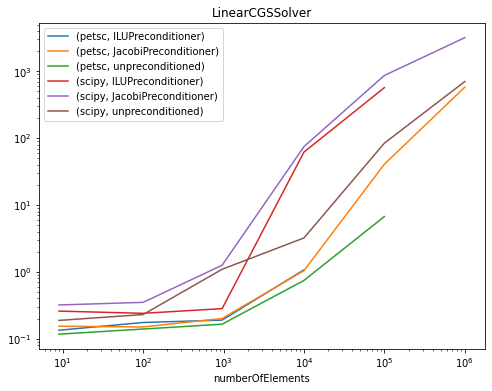

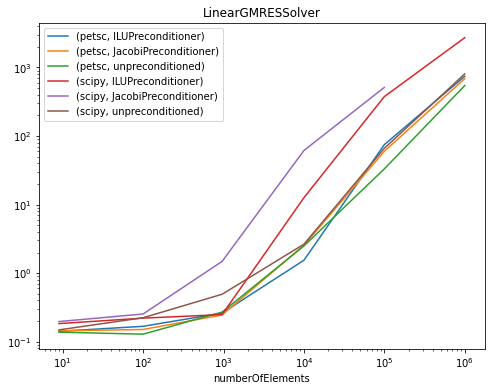

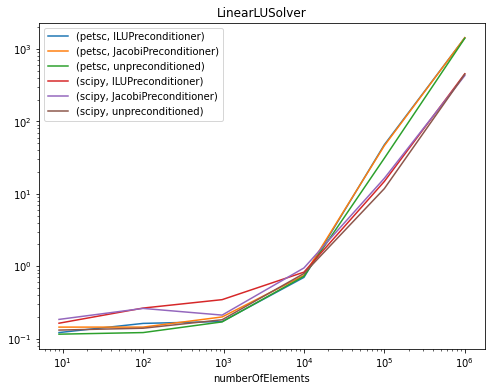

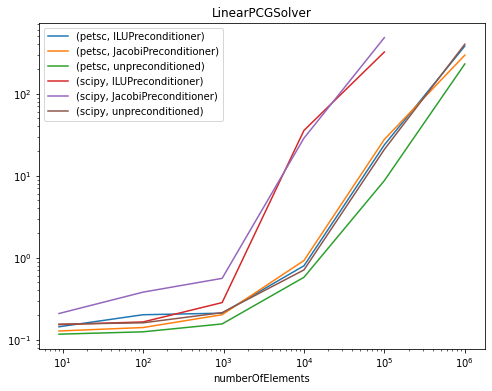

In [295]:
for solver_class, group1 in linuxdf.groupby(["solver_class"]):
    fig, ax = plt.subplots(figsize=(8,6))
    for label, group2 in group1.groupby(["package.solver", "preconditioner"]):
        group2.plot("numberOfElements", "elapsed_seconds", loglog=True, ax=ax, label=label)
    plt.legend()
    plt.title(solver_class)

## harmonic

In [132]:
events = []
for fname in glob.glob("../../../../solvers_and_timings/constant_diffusion/solver.*.log"):
    events.extend(read_events(fname))

constant = events2df(events)
constant_total = extract_total_times(constant)

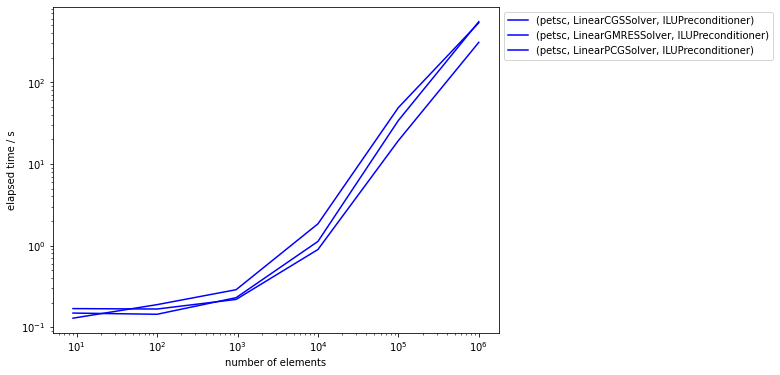

In [133]:
plot_all(constant_total)

In [56]:
events = []
for fname in glob.glob("../../../../solvers_and_timings/harmonic/solver.*.log"):
    events.extend(read_events(fname))

harmonic = events2df(events)
harmonic_total = extract_total_times(harmonic)

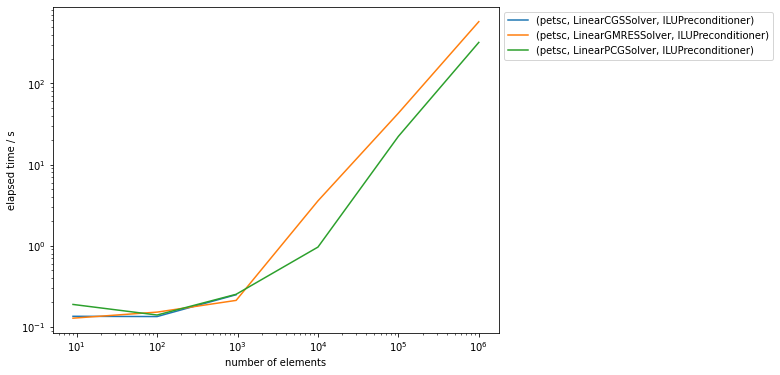

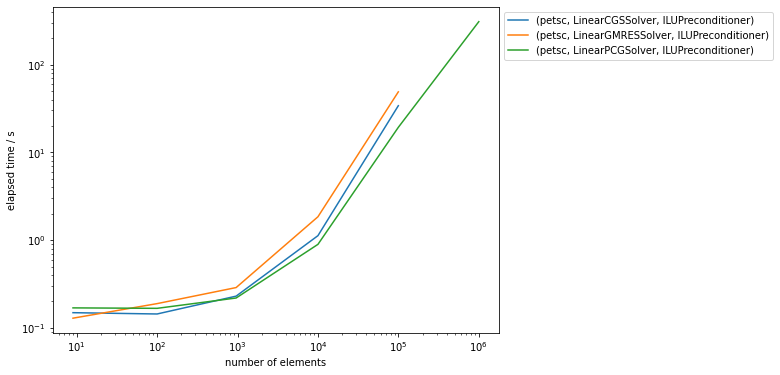

In [57]:
plot_all(harmonic_total)
plot_all(constant_total)

In [135]:
events = []
# for fname in glob.glob("../../../../solvers_and_timings/harmonic/solver.*.log"):
#     events.extend(read_events(fname))
# for fname in glob.glob("../../../../solvers_and_timings/harmonic_right/solver.*.log"):
#     events.extend(read_events(fname))
# for fname in glob.glob("../../../../solvers_and_timings/constant_diffusion/solver.*.log"):
#     events.extend(read_events(fname))
for fname in glob.glob("../../../../solvers_and_timings/arithmetic_diffusion/solver.*.log"):
    events.extend(read_events(fname))

harmonic = events2df(events)
harmonic_total = extract_total_times(harmonic)

(10.0, 1000000.0)

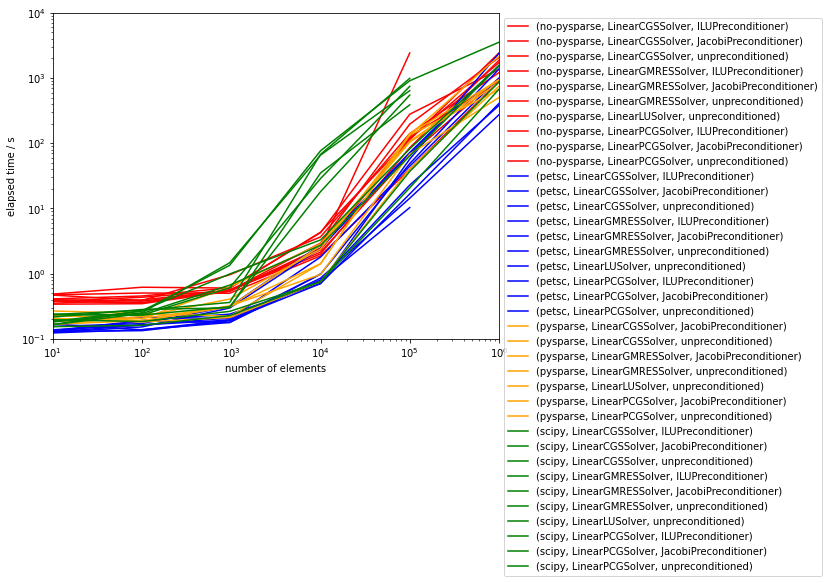

In [136]:
trilinos = harmonic_total["package.solver"] == "no-pysparse"
petsc = harmonic_total["package.solver"] == "petsc"
scipy = harmonic_total["package.solver"] == "scipy"
pysparse = harmonic_total["package.solver"] == "pysparse"

# plot_all(harmonic_total[pysparse | scipy])
plot_all(harmonic_total)
plt.ylim(bottom=1e-1, top=1e4)
plt.xlim(left=1e1, right=1e6)

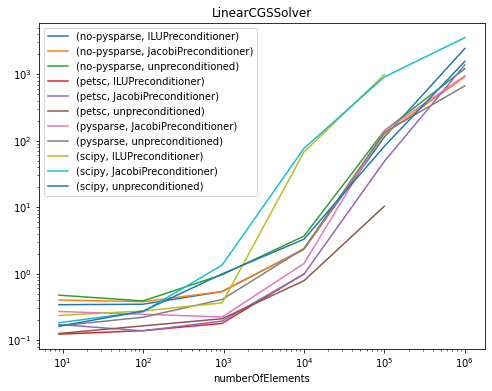

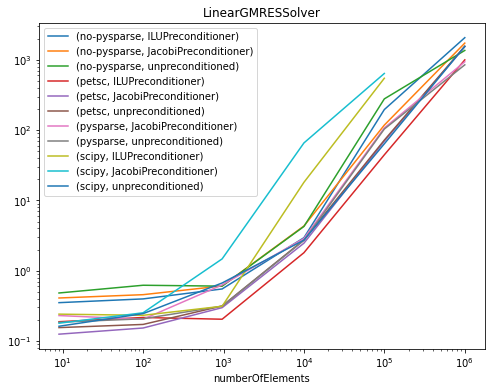

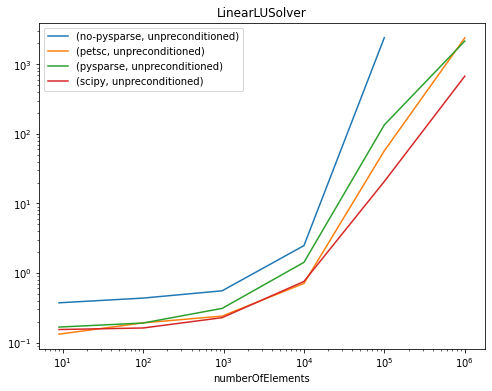

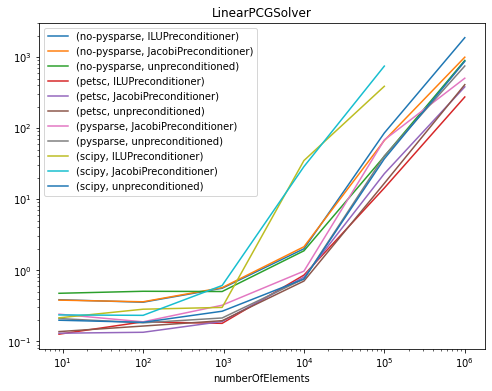

In [152]:
for solver_class, group1 in harmonic_total.groupby(["solver_class"]):
    fig, ax = plt.subplots(figsize=(8,6))
    for label, group2 in group1.groupby(["package.solver", "preconditioner"]):
        group2.plot("numberOfElements", "elapsed_seconds", loglog=True, ax=ax, label=label)
    plt.legend()
    plt.title(solver_class)

In [34]:
events = []
for fname in glob.glob("../../../../solvers_and_timings/harmonic_right/solver.*.log"):
    events.extend(read_events(fname))

harmonic = events2df(events)
harmonic_total = extract_total_times(harmonic)

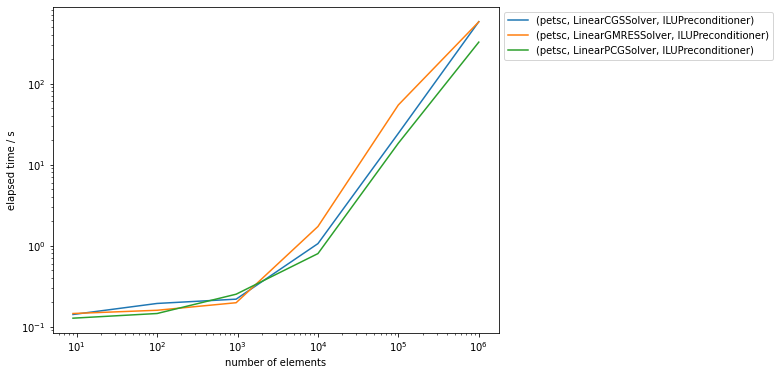

In [35]:
plot_all(harmonic_total)

## nucleation

In [241]:
events = []
for fname in glob.glob("../../../../solvers_and_timings/nucleation2[3,5]/solver.*.log"):
# for fname in glob.glob("../../../../solvers_and_timings/nucleation23/solver.*.log"):
    events.extend(read_events(fname))

nucleation = events2df(events)
nucleation_total = extract_total_times(nucleation)

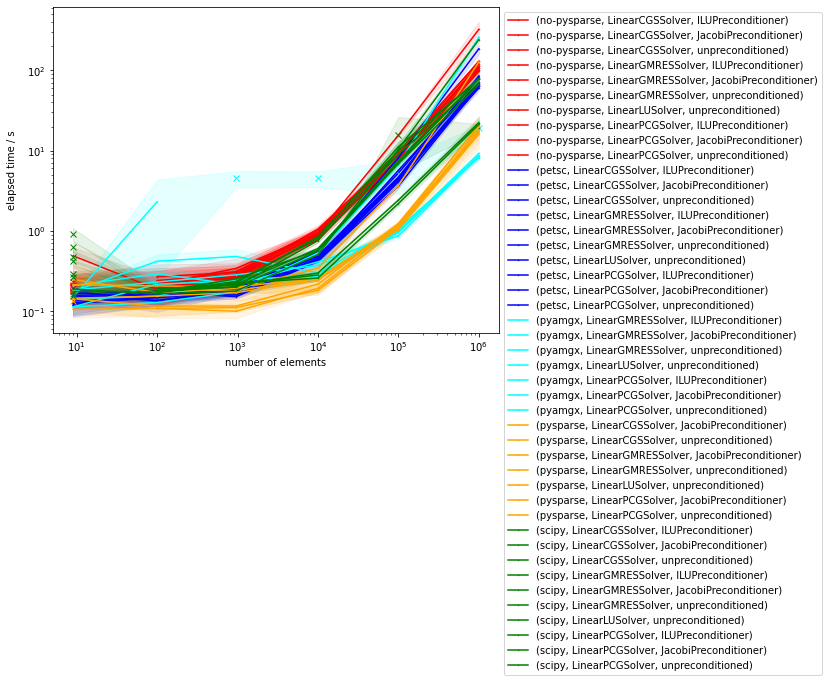

In [314]:
plot_all(nucleation_total)

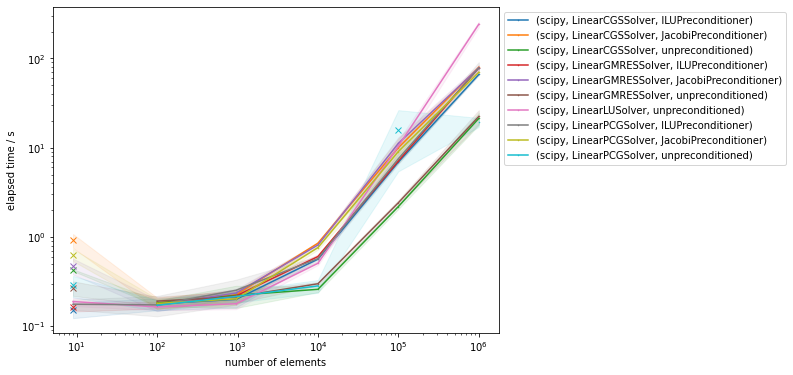

In [317]:
trilinos = nucleation_total["package.solver"] == "no-pysparse"
petsc = nucleation_total["package.solver"] == "petsc"
scipy = nucleation_total["package.solver"] == "scipy"
pysparse = nucleation_total["package.solver"] == "pysparse"
pyamgx = nucleation_total["package.solver"] == "pyamgx"

plot_all(nucleation_total[scipy], color_by_suite=False)
# plot_all(nucleation_total)
# plt.ylim(bottom=1e-1, top=1e3)
# plt.xlim(left=1e1, right=1e6)

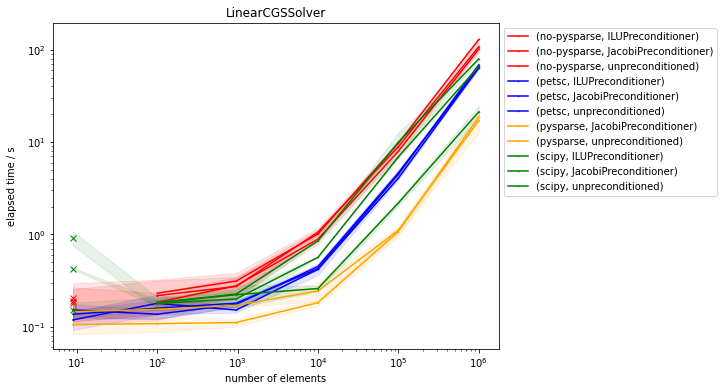

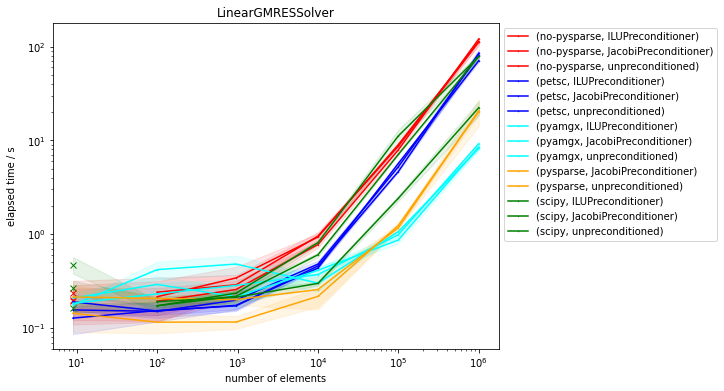

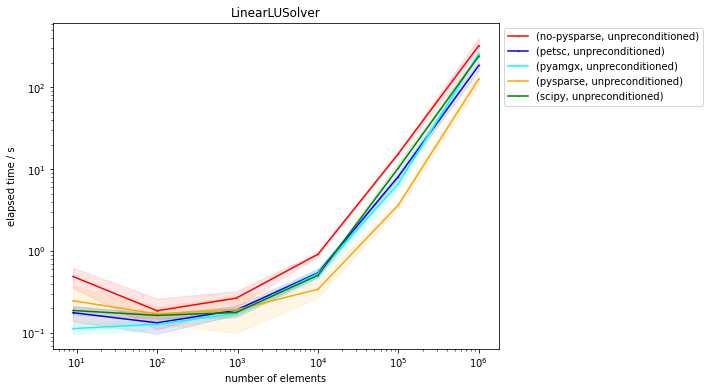

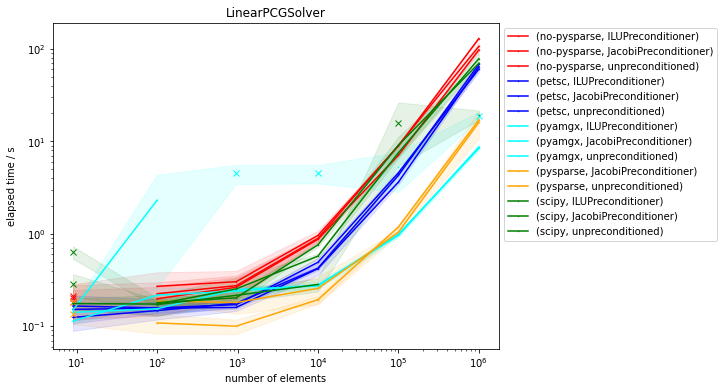

In [312]:
plot_by_solver(nucleation_total)

### pyamgx

In [196]:
events = []
for fname in glob.glob("../../../../solvers_and_timings/nucleation25/solver.*.log"):
    events.extend(read_events(fname))

pyamgx = events2df(events)
pyamgx_total = extract_total_times(pyamgx)

In [288]:
group_by=["package.solver", "solver_class", "preconditioner"]

groups = pyamgx_total.groupby(group_by + ["numberOfElements"])
groups = groups.agg(converged=("converged", "last"),
           elapsed_count=("elapsed_seconds", "count"),
           elapsed_mean=("elapsed_seconds", "mean"),
           elapsed_std=("elapsed_seconds", "std")).reset_index()
groups = groups.groupby(group_by)
# groups["converged"] = pyamgx_total["converged"]
# groups = groups.groupby(group_by)
for key, group in groups:
    display(key)
    display(group.mask(~group["converged"].astype(bool)))
#groups

('pyamgx', 'LinearGMRESSolver', 'ILUPreconditioner')

package.solver       solver_class     preconditioner  numberOfElements  \
0         pyamgx  LinearGMRESSolver  ILUPreconditioner                 9   
1         pyamgx  LinearGMRESSolver  ILUPreconditioner               100   
2         pyamgx  LinearGMRESSolver  ILUPreconditioner               961   
3         pyamgx  LinearGMRESSolver  ILUPreconditioner             10000   
4         pyamgx  LinearGMRESSolver  ILUPreconditioner             99856   
5         pyamgx  LinearGMRESSolver  ILUPreconditioner           1000000   

  converged  elapsed_count  elapsed_mean  elapsed_std  
0      True              2         0.176     0.015556  
1      True              2         0.419     0.127279  
2      True              2         0.481     0.158392  
3      True              2         0.301     0.082024  
4      True              2         1.066     0.055154  
5      True              2         8.208     0.507703

('pyamgx', 'LinearGMRESSolver', 'JacobiPreconditioner')

package.solver       solver_class        preconditioner  numberOfElements  \
6          pyamgx  LinearGMRESSolver  JacobiPreconditioner                 9   
7          pyamgx  LinearGMRESSolver  JacobiPreconditioner               100   
8          pyamgx  LinearGMRESSolver  JacobiPreconditioner               961   
9          pyamgx  LinearGMRESSolver  JacobiPreconditioner             10000   
10         pyamgx  LinearGMRESSolver  JacobiPreconditioner             99856   
11         pyamgx  LinearGMRESSolver  JacobiPreconditioner           1000000   

   converged  elapsed_count  elapsed_mean  elapsed_std  
6       True              2        0.1835     0.020506  
7       True              2        0.2310     0.103238  
8       True              2        0.2845     0.062933  
9       True              2        0.3715     0.102530  
10      True              2        0.9855     0.072832  
11      True              2        9.2255     0.699329

('pyamgx', 'LinearGMRESSolver', 'unpreconditioned')

package.solver       solver_class    preconditioner  numberOfElements  \
12         pyamgx  LinearGMRESSolver  unpreconditioned                 9   
13         pyamgx  LinearGMRESSolver  unpreconditioned               100   
14         pyamgx  LinearGMRESSolver  unpreconditioned               961   
15         pyamgx  LinearGMRESSolver  unpreconditioned             10000   
16         pyamgx  LinearGMRESSolver  unpreconditioned             99856   
17         pyamgx  LinearGMRESSolver  unpreconditioned           1000000   

   converged  elapsed_count  elapsed_mean  elapsed_std  
12      True              2        0.2085     0.041719  
13      True              2        0.2915     0.088388  
14      True              2        0.2155     0.074246  
15      True              2        0.4125     0.044548  
16      True              2        0.8670     0.098995  
17      True              2        8.5320     0.881055

('pyamgx', 'LinearLUSolver', 'unpreconditioned')

package.solver    solver_class    preconditioner  numberOfElements  \
18         pyamgx  LinearLUSolver  unpreconditioned                 9   
19         pyamgx  LinearLUSolver  unpreconditioned               100   
20         pyamgx  LinearLUSolver  unpreconditioned               961   
21         pyamgx  LinearLUSolver  unpreconditioned             10000   
22         pyamgx  LinearLUSolver  unpreconditioned             99856   
23         pyamgx  LinearLUSolver  unpreconditioned           1000000   

   converged  elapsed_count  elapsed_mean  elapsed_std  
18      True              2        0.1135     0.023335  
19      True              2        0.1285     0.024749  
20      True              2        0.1740     0.018385  
21      True              2        0.5330     0.123037  
22      True              2        6.6660     1.501895  
23      True              2      259.5030    13.152186

('pyamgx', 'LinearPCGSolver', 'ILUPreconditioner')

package.solver     solver_class     preconditioner  numberOfElements  \
24         pyamgx  LinearPCGSolver  ILUPreconditioner               9.0   
25            NaN              NaN                NaN               NaN   
26            NaN              NaN                NaN               NaN   
27            NaN              NaN                NaN               NaN   
28         pyamgx  LinearPCGSolver  ILUPreconditioner           99856.0   
29            NaN              NaN                NaN               NaN   

   converged  elapsed_count  elapsed_mean  elapsed_std  
24      True            2.0        0.1495     0.019092  
25       NaN            NaN           NaN          NaN  
26       NaN            NaN           NaN          NaN  
27       NaN            NaN           NaN          NaN  
28      True            2.0        5.2405     3.394820  
29       NaN            NaN           NaN          NaN

('pyamgx', 'LinearPCGSolver', 'JacobiPreconditioner')

package.solver     solver_class        preconditioner  numberOfElements  \
30         pyamgx  LinearPCGSolver  JacobiPreconditioner                 9   
31         pyamgx  LinearPCGSolver  JacobiPreconditioner               100   
32         pyamgx  LinearPCGSolver  JacobiPreconditioner               961   
33         pyamgx  LinearPCGSolver  JacobiPreconditioner             10000   
34         pyamgx  LinearPCGSolver  JacobiPreconditioner             99856   
35         pyamgx  LinearPCGSolver  JacobiPreconditioner           1000000   

   converged  elapsed_count  elapsed_mean  elapsed_std  
30      True              2        0.1135     0.010607  
31      True              2        0.2170     0.060811  
32      True              2        0.2395     0.024749  
33      True              2        0.2785     0.037477  
34      True              2        0.9580     0.070711  
35      True              2        8.7030     0.376181

('pyamgx', 'LinearPCGSolver', 'unpreconditioned')

package.solver     solver_class    preconditioner  numberOfElements  \
36         pyamgx  LinearPCGSolver  unpreconditioned                 9   
37         pyamgx  LinearPCGSolver  unpreconditioned               100   
38         pyamgx  LinearPCGSolver  unpreconditioned               961   
39         pyamgx  LinearPCGSolver  unpreconditioned             10000   
40         pyamgx  LinearPCGSolver  unpreconditioned             99856   
41         pyamgx  LinearPCGSolver  unpreconditioned           1000000   

   converged  elapsed_count  elapsed_mean  elapsed_std  
36      True              2        0.1410     0.009899  
37      True              2        0.1545     0.014849  
38      True              2        0.2490     0.035355  
39      True              2        0.2725     0.020506  
40      True              2        0.9870     0.063640  
41      True              2        8.3745     0.634275

Text(0.5, 1.0, 'pyamgx')

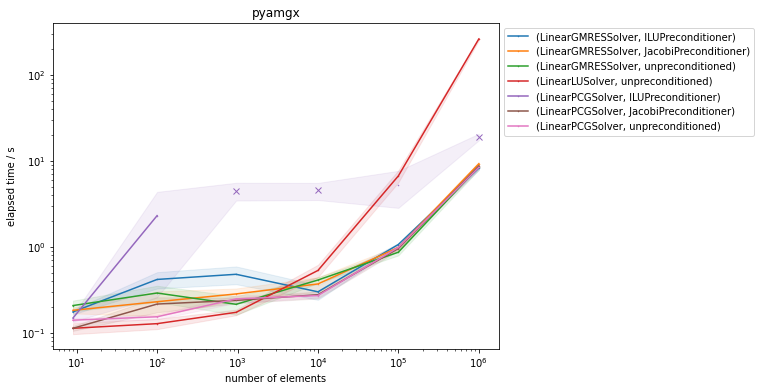

In [311]:
plot_all(pyamgx_total, color_by_suite=False, group_by=["solver_class", "preconditioner"])
plt.title("pyamgx")

## Compare solutions

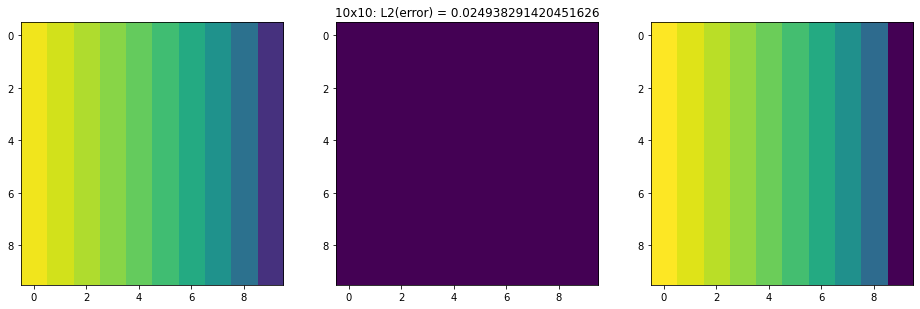

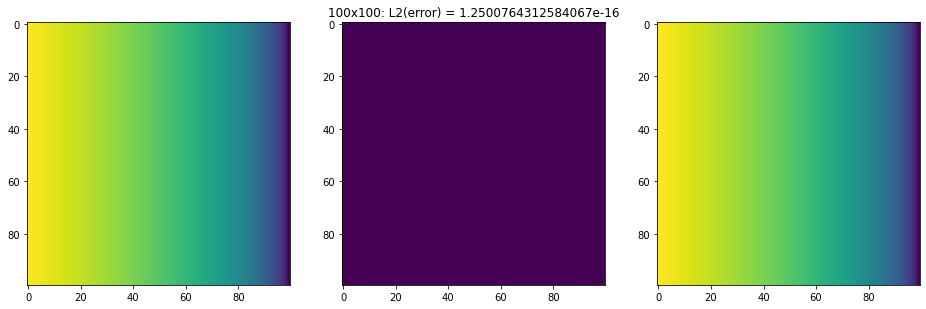

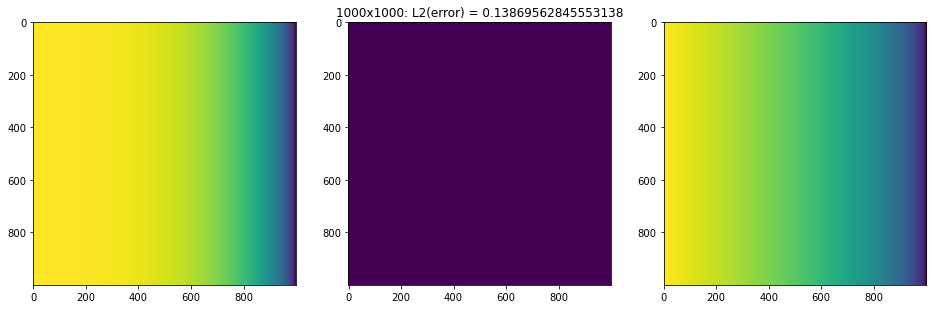

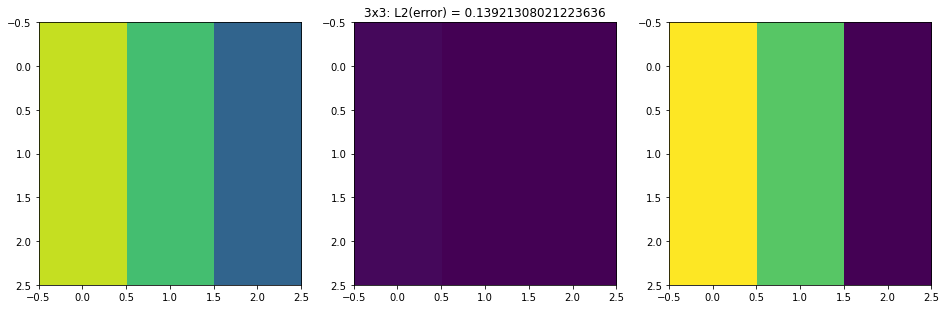

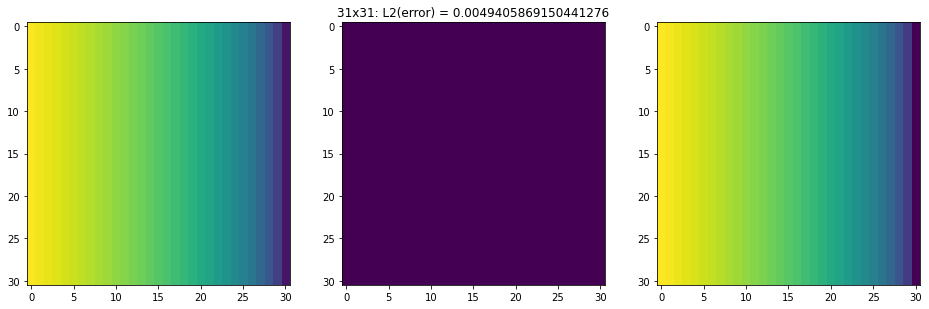

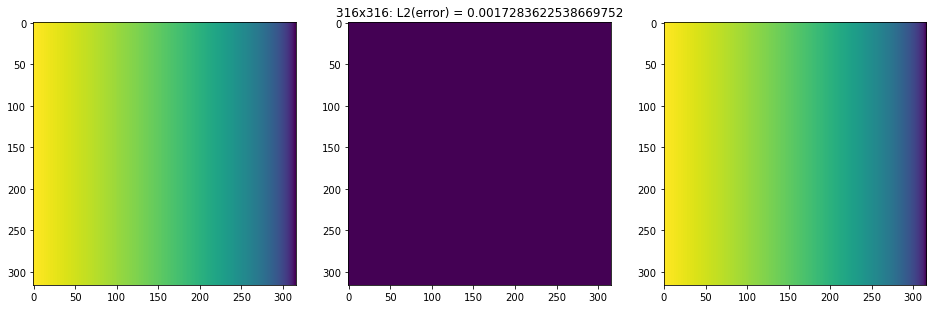

In [57]:
reference = "gpu/pyamgx/LinearGMRESSolver/10000/solution.tsv"
datasets = glob.glob("gpu/pyamgx/LinearGMRESSolver/*/solution.tsv")
datasets.sort()
for dataset in datasets:
    compare(dataset, reference)

In [125]:
for path in glob.glob("linux/petsc/LinearPCGSolver/*/*/solution.tsv"):
    tsv2npz(path)

In [354]:
for path in glob.glob("linux/petsc/LinearGMRESSolver/*/*/solution.tsv"):
    tsv2npz(path)

In [355]:
for path in glob.glob("linux/petsc/LinearCGSSolver/*/*/solution.tsv"):
    tsv2npz(path)

In [356]:
for path in glob.glob("linux/petsc/LinearLUSolver/*/*/solution.tsv"):
    tsv2npz(path)

In [357]:
for path in glob.glob("linux/scipy/*/*/*/solution.tsv"):
    tsv2npz(path)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/2948526623.py:31: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


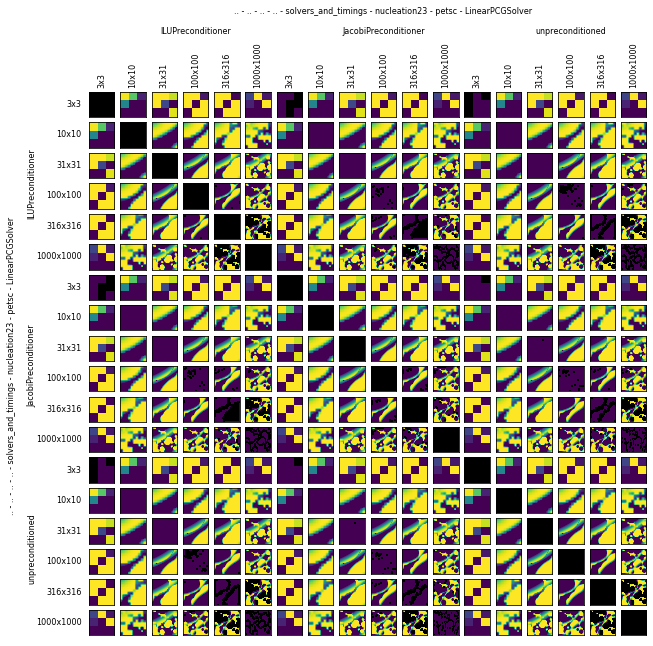

In [50]:
plot_error_matrix("../../../../solvers_and_timings/nucleation23/petsc/LinearPCGSolver/*/*/t=301.0.npz",
                  "../../../../solvers_and_timings/nucleation23/petsc/LinearPCGSolver/*/*/t=301.0.npz",
                  nucleation, key="phi")

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/2948526623.py:31: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


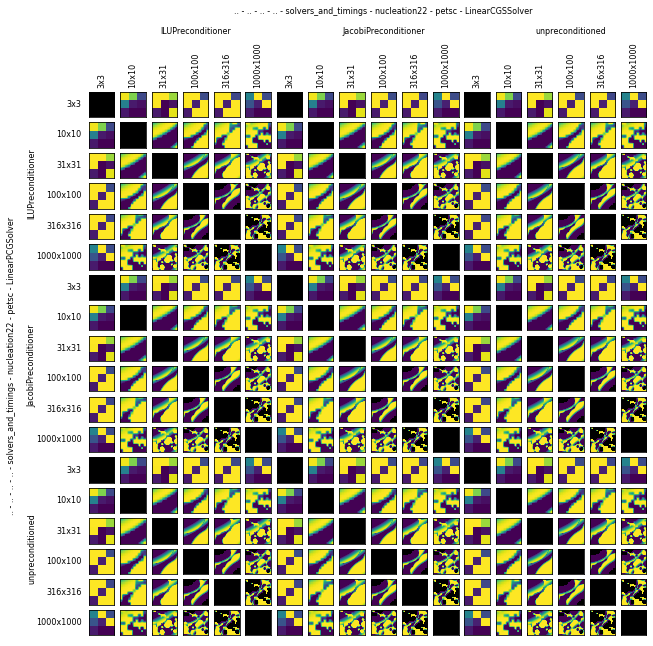

In [46]:
plot_error_matrix("../../../../solvers_and_timings/nucleation22/petsc/LinearCGSSolver/*/*/t=300.0.npz",
                  "../../../../solvers_and_timings/nucleation22/petsc/LinearPCGSolver/*/*/t=300.0.npz",
                  nucleation, key="phi")

In [31]:
%debug

> /var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/4215461971.py(4)is_converged()
      2     converged = {}
      3     for path in paths:
----> 4         _, suite, solver, preconditioner, numberOfElements, _ = path.split('/')
      5         if preconditioner == "NoneType":
      6             preconditioner = "unpreconditioned"



ipdb>  path.split('/')


['..', '..', '..', '..', 'solvers_and_timings', 'nucleation22', 'petsc', 'LinearPCGSolver', 'ILUPreconditioner', '9', 't=300.0.npz']


ipdb>  q


In [42]:
plot_error_matrix("../../../../solvers_and_timings/harmonic/petsc/LinearPCGSolver/*/*/solution.npz",
                  "../../../../solvers_and_timings/harmonic_right/scipy/LinearPCGSolver/*/*/solution.npz",
                  harmonic)

ValueError: too many values to unpack (expected 6)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_69873/2078872991.py:31: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


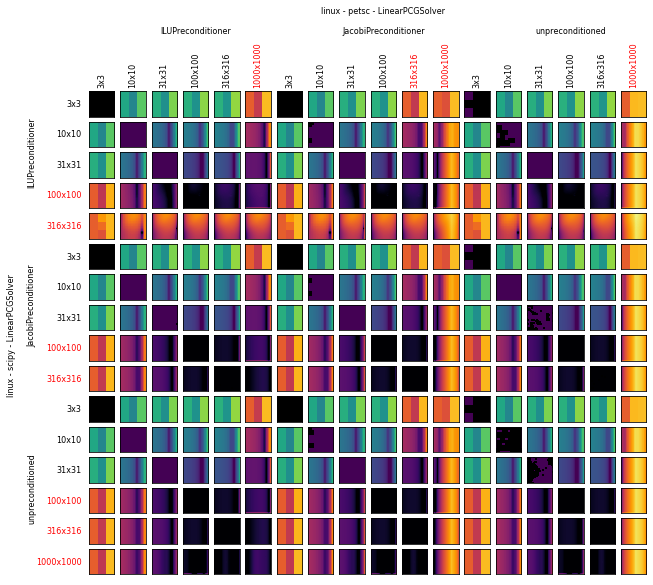

In [352]:
plot_error_matrix("linux/petsc/LinearPCGSolver/*/*/solution.npz",
                  "linux/scipy/LinearPCGSolver/*/*/solution.npz",
                  linux)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_69873/2078872991.py:31: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


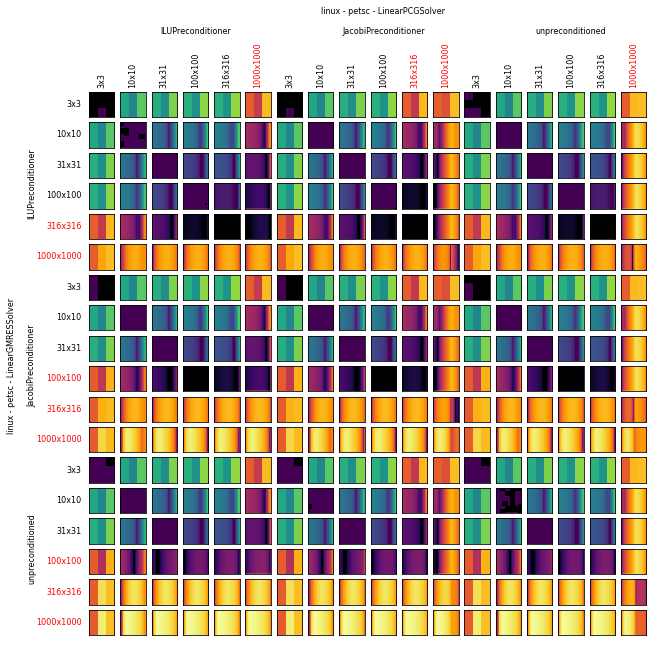

In [358]:
plot_error_matrix("linux/petsc/LinearPCGSolver/*/*/solution.npz",
                  "linux/petsc/LinearGMRESSolver/*/*/solution.npz",
                  linux)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_69873/2078872991.py:31: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


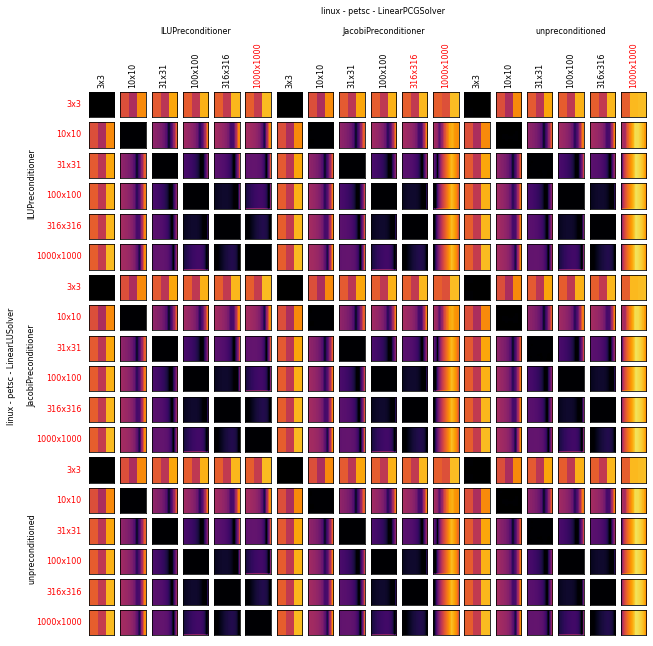

In [359]:
plot_error_matrix("linux/petsc/LinearPCGSolver/*/*/solution.npz",
                  "linux/petsc/LinearLUSolver/*/*/solution.npz",
                  linux)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_69873/2078872991.py:31: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


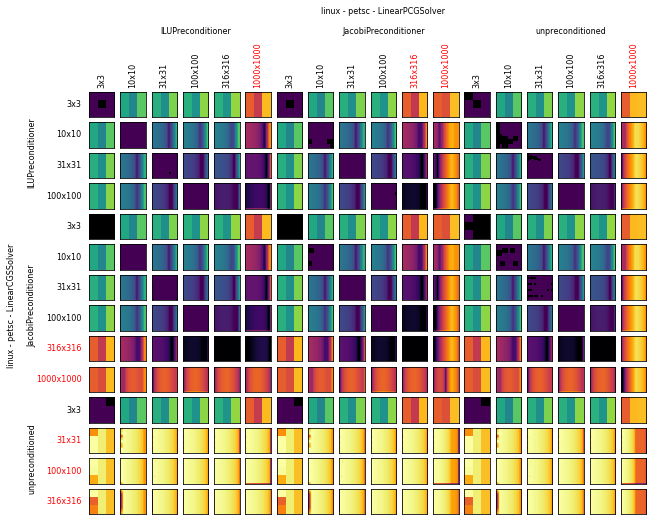

In [360]:
plot_error_matrix("linux/petsc/LinearPCGSolver/*/*/solution.npz",
                  "linux/petsc/LinearCGSSolver/*/*/solution.npz",
                  linux)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_69873/2078872991.py:31: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


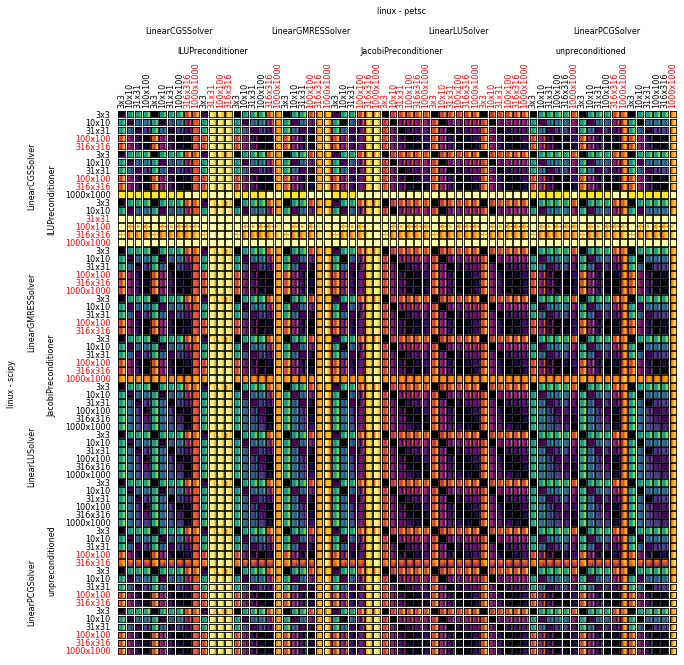

In [361]:
plot_error_matrix("linux/petsc/*/*/*/solution.npz",
                  "linux/scipy/*/*/*/solution.npz",
                  linux)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_69873/2078872991.py:31: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


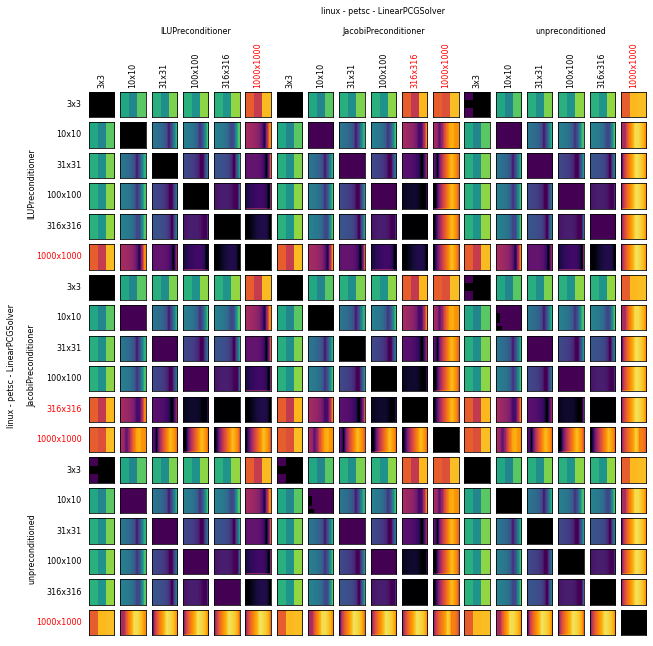

In [353]:
plot_error_matrix("linux/petsc/LinearPCGSolver/*/*/solution.npz",
                  "linux/petsc/LinearPCGSolver/*/*/solution.npz",
                  linux)